Data is [here](https://cycling.data.tfl.gov.uk)

Next steps:
- Find way to read in all csvs from website fast
- Improve matplotlib plots

In [3]:
import os
import glob
import janitor
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

# # Save altair graph data locally to specified directory
# def json_dir(data, data_dir='altair_data'):
#     os.makedirs(data_dir, exist_ok=True)
#     return alt.pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )
# alt.data_transformers.register('json_dir', json_dir)
# alt.data_transformers.enable('json_dir', data_dir='./data/altair_data')

# Prepare data

In [4]:
# Load sample data

files = glob.glob('./data/*Dec2019.csv')
df = (
    pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    .clean_names()
)

In [5]:
# Extra variable operations

df['end_date'] = pd.to_datetime(df['end_date'], format='%d/%m/%Y %H:%M')
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y %H:%M')
df['duration'] = df['duration'] / 60
df = df[df['start_date'].dt.month == 12]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585492 entries, 2 to 683755
Data columns (total 9 columns):
rental_id            585492 non-null int64
duration             585492 non-null float64
bike_id              585492 non-null int64
end_date             585492 non-null datetime64[ns]
endstation_id        585492 non-null int64
endstation_name      585492 non-null object
start_date           585492 non-null datetime64[ns]
startstation_id      585492 non-null int64
startstation_name    585492 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 44.7+ MB


# When do people rent cycles?

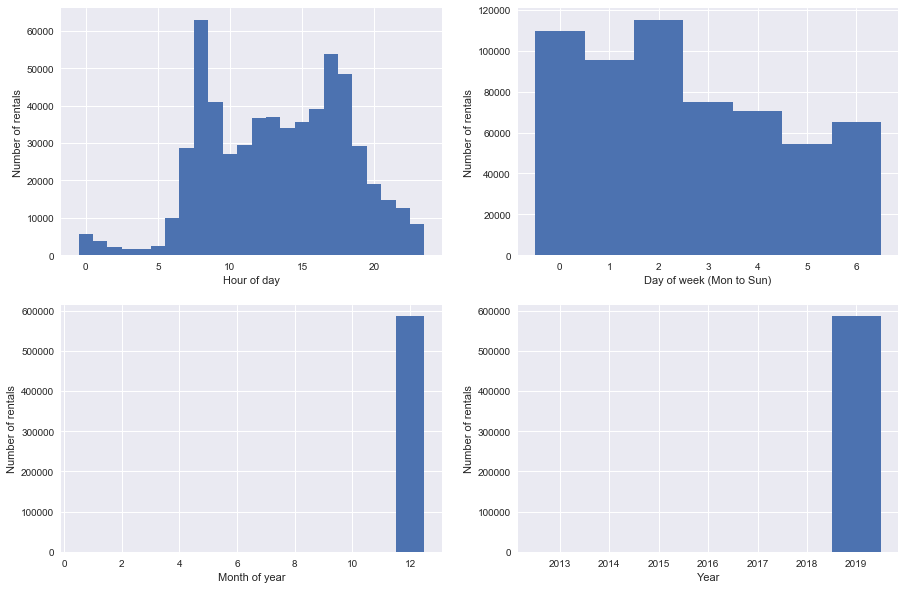

In [50]:
plt.figure(figsize=(15,10))

# By hour of day
plt.subplot(221)
plt.hist(df['start_date'].dt.hour, bins=np.arange(0, 25)-0.5)
plt.xlabel('Hour of day')
plt.ylabel('Number of rentals')

# By day of week
plt.subplot(222)
plt.hist(df['start_date'].dt.weekday, bins=np.arange(0, 8)-0.5)
plt.xlabel('Day of week (Mon to Sun)')
plt.ylabel('Number of rentals')

# By month of year
plt.subplot(223)
plt.hist(df['start_date'].dt.month, bins=np.arange(1,14)-0.5);
plt.xlabel('Month of year')
plt.ylabel('Number of rentals')

# By year
plt.subplot(224)
plt.hist(df['start_date'].dt.year, bins=np.arange(2013,2021)-0.5)
plt.xlabel('Year')
plt.ylabel('Number of rentals');

The patterns in hourly and dayly rentals suggest that quite a few people use bikes for their commute to work. Let's look into this further.

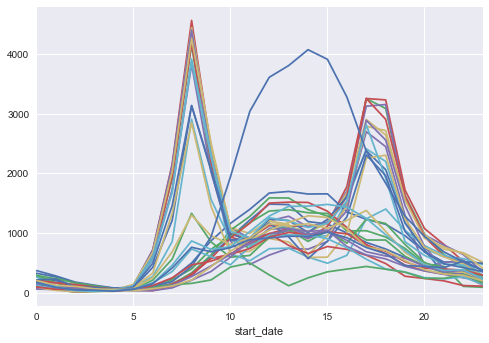

In [52]:
# Create a pivot table with counts
pivoted = df.pivot_table('rental_id',
               index=df['start_date'].dt.hour,
               columns=df['start_date'].dt.date,
               aggfunc='count'
              )

pivoted.plot(legend=None);

In [291]:
grouped = df.groupby(['start_date', 'hour']).count()
counts = grouped[['rental_id']].rename(columns={'rental_id':'rentals'}).reset_index()
counts['weekday'] = counts['start_date'].dt.weekday
counts['date'] = counts['start_date'].dt.date
counts

,start_date,hour,rentals,weekday,date
0,2019-12-01 00:00:00,0,10,6,2019-12-01
1,2019-12-01 00:01:00,0,6,6,2019-12-01
2,2019-12-01 00:02:00,0,6,6,2019-12-01
3,2019-12-01 00:03:00,0,6,6,2019-12-01
4,2019-12-01 00:04:00,0,8,6,2019-12-01
...,...,...,...,...,...
40424,2019-12-31 23:52:00,23,4,1,2019-12-31
40425,2019-12-31 23:53:00,23,2,1,2019-12-31
40426,2019-12-31 23:54:00,23,1,1,2019-12-31
40427,2019-12-31 23:55:00,23,1,1,2019-12-31


Londoners made the most of the [free](https://tfl.gov.uk/status-updates/major-works-and-events/christmas-day-2019) cycles on Christmas day. 